# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Land-Ocean contrasts under climate change

## A recent tweet that caught my attention...

In [1]:
%%HTML
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">actual trends <a href="https://t.co/abnDJGeawr">pic.twitter.com/abnDJGeawr</a></p>&mdash; Gavin Schmidt (@ClimateOfGavin) <a href="https://twitter.com/ClimateOfGavin/status/1117136233409536000?ref_src=twsrc%5Etfw">April 13, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

Statistics such as the global average or zonal average temperature do not tell the whole story about climate change!

## Some observational results on land-ocean warming differences from a recent paper

<img src='https://www.pnas.org/content/pnas/115/19/4863/F1.large.jpg' width="500">

> A–C) Surface-air annual (A) temperature, (B) specific humidity, and (C) relative humidity anomalies averaged from 40∘S to 40∘N and best-fit trends (1979–2016) over land (red solid lines and asterisks) and ocean (blue lines and asterisks). The best-fit trends in the land–ocean contrasts in temperature and specific humidity (δTL−δTO and δqL−δqO, respectively) are also plotted (black asterisks). Land values are from the HadISDH dataset (13, 14) and ocean values are from the ERA-Interim reanalysis (15). Ocean specific humidity anomalies are calculated assuming fixed climatological relative humidity (Materials and Methods). Also shown are land anomalies and associated trends (dashed lines and circles) estimated using the simple theory (Eqs. 2–4) and subsampled to the months and gridboxes for which HadISDH observations are available. Error bars on the trends indicate the 90% confidence intervals corrected to account for serial correlation (Materials and Methods).

Byrne and O'Gorman (2018): Trends in continental temperature and humidity directly linked to ocean warming, PNAS 115 (19) 4863-4868, https://doi.org/10.1073/pnas.1722312115

## Looking at land-ocean warming patterns in the CESM

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

The following repeats the calculation we already did of the Equilibrium Climate Sensitity (ECS) and Transient Climate Response (TCR):

In [3]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'
    
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


In [4]:
# extract the last 10 years from the slab ocean control simulation
nyears_som = 10
# and the last 20 years from the coupled control
nyears_cpl = 20
clim_slice_som = slice(-(nyears_som*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

In [5]:
Tmap_cpl_2x = atm['cpl_CO2ramp'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
Tmap_cpl_control = atm['cpl_control'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
DeltaTmap_cpl = Tmap_cpl_2x - Tmap_cpl_control

Tmap_som_2x = atm['som_2xCO2'].TREFHT.isel(time=clim_slice_som).mean(dim='time')
Tmap_som_control = atm['som_control'].TREFHT.isel(time=clim_slice_som).mean(dim='time')
DeltaTmap_som = Tmap_som_2x - Tmap_som_control

In [6]:
def make_map(field):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    cx = mapax.contourf(field.lon, field.lat, field, transform=ccrs.PlateCarree())
    mapax.set_global(); mapax.coastlines();
    plt.colorbar(cx, cax=barax, orientation='horizontal')
    plotax.plot(field.mean(dim='lon'), field.lat)
    plotax.set_ylabel('Latitude')
    plotax.grid()
    return fig, (mapax, plotax, barax), cx

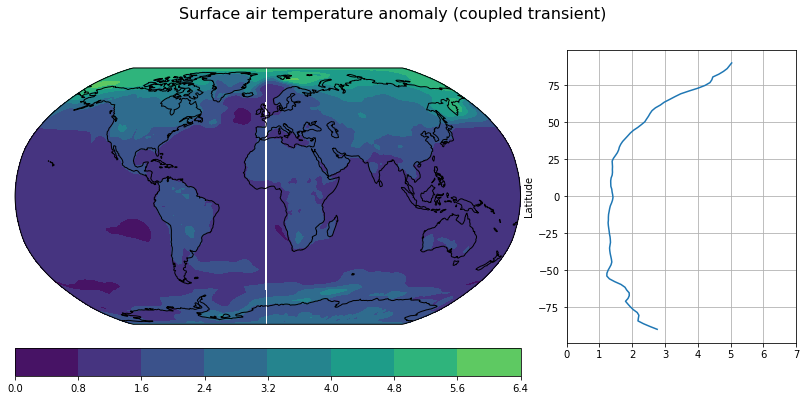

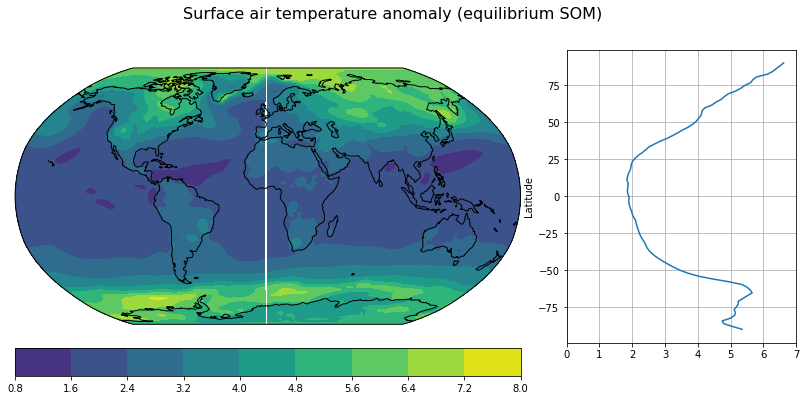

In [7]:
fig, axes, cx = make_map(DeltaTmap_cpl)
fig.suptitle('Surface air temperature anomaly (coupled transient)', fontsize=16);
axes[1].set_xlim(0,7)  # ensure the line plots have same axes
cx.set_clim([0, 8])    # ensure the contour maps have the same color intervals

fig, axes,cx  = make_map(DeltaTmap_som)
fig.suptitle('Surface air temperature anomaly (equilibrium SOM)', fontsize=16);
axes[1].set_xlim(0,7)
cx.set_clim([0, 8])

In [8]:
def global_mean(field, weight=atm['som_control'].gw):
    '''Return the area-weighted global average of the input field'''
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

ECS = global_mean(DeltaTmap_som)
TCR = global_mean(DeltaTmap_cpl)

print('The Equilibrium Climate Sensitivity is {:.3} K.'.format(float(ECS)))
print('The Transient Climate Response is {:.3} K.'.format(float(TCR)))

The Equilibrium Climate Sensitivity is 2.89 K.
The Transient Climate Response is 1.67 K.


In [9]:
# for name in casenames:
#     atm[name].TREFHT.load()

Text(0.5,0.98,'Places that warm more than the global mean in CESM simulations')

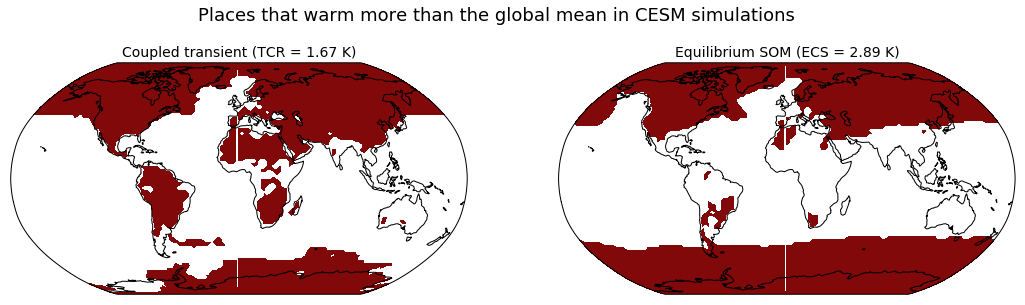

In [10]:
# Make a map like Gavin's...  places where warming is > global average
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
ax1.contourf(DeltaTmap_cpl.lon, DeltaTmap_cpl.lat, 
             DeltaTmap_cpl.where(DeltaTmap_cpl>TCR), 
             levels=[0, 100], colors='#81090A',
             transform=ccrs.PlateCarree())
ax1.set_title('Coupled transient (TCR = {:.3} K)'.format(float(TCR)), fontsize=14)
ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
ax2.contourf(DeltaTmap_som.lon, DeltaTmap_som.lat, 
             DeltaTmap_som.where(DeltaTmap_som>ECS), 
             levels=[0, 100], colors='#81090A',
             transform=ccrs.PlateCarree())
ax2.set_title('Equilibrium SOM (ECS = {:.3} K)'.format(float(ECS)), fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global(); ax.coastlines();

fig.suptitle('Places that warm more than the global mean in CESM simulations', fontsize=18)

## Key Point

The **enhanced warming over land** is not just a feature of the transient, but is also found in the equilibrium response!

We cannot understand this result solely in terms of heat capacity differences.

**This motivates some detailed study of surface processes and the climatic coupling between land and ocean.**